#Install dependencies

In [ ]:
!pip install -q torchinfo
!pip install einops
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

#Código

##Data

In [ ]:
from datasets import load_dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchinfo import summary
from einops import rearrange, repeat
import os
import pickle
import random

In [ ]:
ds = load_dataset("ylecun/mnist")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Define a transform to convert PIL images to tensors
stats = ((0.1307),(0.3081))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats,inplace=True)  # Convert PIL Image to PyTorch Tensor
])

# Update the datasets to use the transform
train_dataset = ImageDataset(ds['train'], transform=transform)
valid_dataset = ImageDataset(ds['test'], transform=transform)

In [ ]:
Batch_size = 500

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=Batch_size, shuffle=False, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Check device

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
device = get_default_device()
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
class Base(nn.Module):
    def training_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.mse_loss(out, images)
        return loss

    def validation_step(self, images):
        out = self(images)
        loss = F.mse_loss(out, images)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

##Model

In [ ]:
class Autoencoder(Base):
    """
    Autoencoder represents a Deep Convolutional autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim,
                 d_model):
        super(Autoencoder, self).__init__()

        self.input_shape = input_shape #28
        self.conv_filters = conv_filters # (28, 32, 64, 64)
        self.conv_kernels = conv_kernels # (3, 3, 3, 3)
        self.conv_strides = conv_strides # (1, 2, 2, 1)
        self.latent_space_dim = latent_space_dim # 2
        self.d_model = d_model
        self.reconstruction_loss_weight = 1000
        self.encoder = None
        self.decoder = None
        self.model = None

        self._model_input = None
        self.layers = nn.ModuleList()
        self.return_layers = nn.ModuleList()
        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self.num_neurons = 0
        self._build()



    #Creating Autoencoder
    def _build(self):
        self._build_encoder()
        self._build_decoder()

    def _build_encoder(self):
        self.encoder = self._add_encoder_layers()
        self.bottleneck = self._add_bottleneck()

    def _add_bottleneck(self):
        return nn.Sequential(nn.Flatten(),nn.Linear(self.d_model, self.latent_space_dim))

    def _build_decoder(self):
        self.return_layer = self._add_bottleneck_layer()
        self.decoder = self._add_decoder_layers()
        self.outputDecoder = self._add_output_layer()

    def _add_encoder_layers(self):
        in_channels = self.input_shape
        for out_channels, kernel_size, stride in zip( self.conv_filters,  self.conv_kernels, self.conv_strides):
            self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,padding=1))
            in_channels = out_channels
        return self.layers

    def _add_bottleneck_layer(self):
        return nn.Linear(self.latent_space_dim, self.d_model)

    def _add_decoder_layers(self):#(28, 32, 64, 64) # (1, 2, 2, 1)
        in_channels = self.conv_filters[self._num_conv_layers-1]
        for index in reversed(range(1, self._num_conv_layers)):
              index_output = index - 1
              out = self.conv_strides[index] - 1
              self.return_layers.append(nn.ConvTranspose2d(self.conv_filters[index], self.conv_filters[index_output], self.conv_kernels[index], stride=self.conv_strides[index],padding=1,output_padding=out))
        return self.return_layers

    def _add_output_layer(self):
        return nn.ConvTranspose2d(self.conv_filters[0], 1, self.conv_kernels[0], stride=self.conv_strides[0],padding=1)

    #Compiling autoencoder
    def forward(self, x):
        for conv_layer in self.encoder:
            x = conv_layer(x)
            x = nn.ReLU()(x)
            x = nn.BatchNorm2d(x.shape[1]).to(x.device)(x)
        x = self.bottleneck(x)
        x = self.return_layer(x)
        x = x.view(-1, 64, 7, 7)
        for convT_layer in self.decoder:
            x = convT_layer(x)
            x = nn.ReLU()(x)
            x = nn.BatchNorm2d(x.shape[1]).to(x.device)(x)
        x = self.outputDecoder(x)
        x = nn.Sigmoid()(x)
        return x

      #Saving latent space
    def reconstruct(self, x):
        for conv_layer in self.encoder:
            x = conv_layer(x)
            x = nn.ReLU()(x)
            x = nn.BatchNorm2d(x.shape[1]).to(x.device)(x)
        latent_representations = self.bottleneck(x)
        x = self.return_layer(latent_representations)
        x = x.view(-1, 64, 7, 7)
        for convT_layer in self.decoder:
            x = convT_layer(x)
            x = nn.ReLU()(x)
            x = nn.BatchNorm2d(x.shape[1]).to(x.device)(x)
        x = self.outputDecoder(x)
        reconstructed_images = nn.Sigmoid()(x)
        return reconstructed_images, latent_representations

In [ ]:
in_chanel= 1
out_channels = (32, 64, 64, 64)
Kernels = (3, 3, 3, 3)
strides = (1, 2, 2, 1)
letent_space = 2
d_model = 3136 # 7*7*64
model_ac = to_device(Autoencoder(in_chanel, out_channels, Kernels, strides, letent_space, d_model), device)

##Training

In [ ]:
@torch.no_grad()
def evaluate(model_ac, val_loader):
    model_ac.eval()
    outputs = [model_ac.validation_step(batch) for batch,labels in val_loader]
    return model_ac.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
#metrics=[self._calculate_reconstruction_loss, self._calculate_kl_loss]
def try_model(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        model.train()
        train_losses = []
        outlist = []
        batchlist = []
        lrs = []

        for batch in train_loader:

            optimizer.zero_grad()
            loss = model.training_step(batch)
            train_losses.append(loss)

            loss.backward()

            if grad_clip:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
#epochs = 100
#max_lr = 0.001
#grad_clip = 0.0001
#weight_decay = 1e-4
#opt_func = torch.optim.Adam

epochs = 20
max_lr = 0.01
grad_clip = 0.0001
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(model_ac, train_dl)]
history

[{'val_loss': 10.484823226928711}]

In [ ]:
history += try_model(epochs, max_lr, model_ac, train_dl, valid_dl,weight_decay, grad_clip,
                             opt_func=opt_func)

Epoch [0], train_loss: 0.9247, val_loss: 0.5901
Epoch [1], train_loss: 0.5728, val_loss: 0.5644
Epoch [2], train_loss: 0.5477, val_loss: 0.5290
Epoch [3], train_loss: 0.5244, val_loss: 0.5163
Epoch [4], train_loss: 0.5032, val_loss: 0.5048
Epoch [5], train_loss: 0.4988, val_loss: 0.4956
Epoch [6], train_loss: 0.4893, val_loss: 0.4910
Epoch [7], train_loss: 0.4876, val_loss: 0.4908
Epoch [8], train_loss: 0.4806, val_loss: 0.4913
Epoch [9], train_loss: 0.4753, val_loss: 0.4921
Epoch [10], train_loss: 0.4694, val_loss: 0.4806
Epoch [11], train_loss: 0.4634, val_loss: 0.4599
Epoch [12], train_loss: 0.4539, val_loss: 0.4610
Epoch [13], train_loss: 0.4450, val_loss: 0.4455
Epoch [14], train_loss: 0.4348, val_loss: 0.4458
Epoch [15], train_loss: 0.4258, val_loss: 0.4330
Epoch [16], train_loss: 0.4164, val_loss: 0.4245
Epoch [17], train_loss: 0.4054, val_loss: 0.4179
Epoch [18], train_loss: 0.3959, val_loss: 0.4120
Epoch [19], train_loss: 0.3903, val_loss: 0.4106


In [ ]:
save_path = "/content/drive/MyDrive/Data_AudioGen/weights.pth"
torch.save(model_ac.state_dict(), save_path)

In [ ]:
saved_path = "/content/drive/MyDrive/Data_AudioGen/weights.pth"
weights = torch.load(saved_path,map_location=torch.device('cpu'))
model_ac.load_state_dict(weights)

<All keys matched successfully>

##Analysis

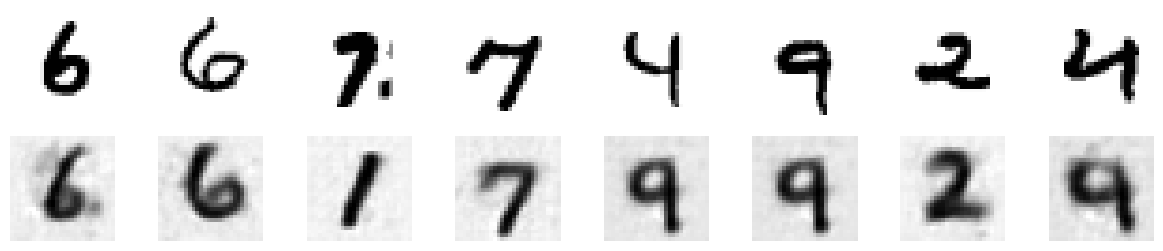

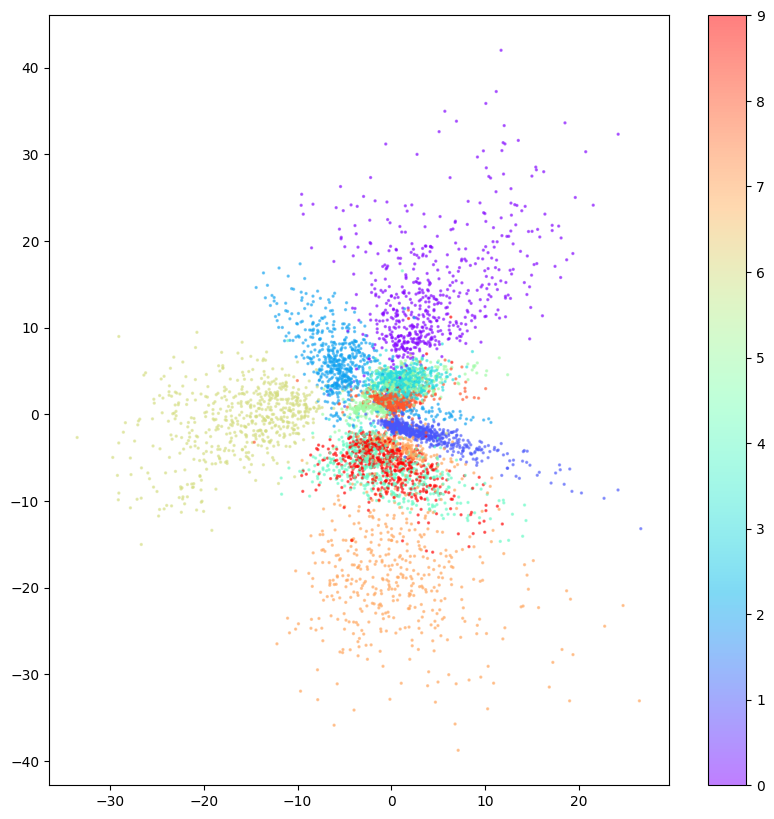

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def select_images(ds, num_images=10):
    indices = random.sample(range(len(ds['train'])), num_images)
    sampled_dataset = ds['train'].select(indices)
    sampled_dataset = ImageDataset(sampled_dataset, transform=transform)
    sampled_dataset = DataLoader(sampled_dataset, batch_size=num_images, shuffle=True, num_workers=3, pin_memory=True)
    return sampled_dataset

def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()

def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

num_sample_images_to_show = 8
sample_images  = select_images(ds, num_sample_images_to_show)
for images,labels in sample_images:
  reconstructed_images,_ = model_ac.reconstruct(images)
  plot_reconstructed_images(images, reconstructed_images.detach().numpy())

num_images = 6000
sample_images = select_images(ds, num_images)
for images,labels in sample_images:
  _, latent_representations = model_ac.reconstruct(images)
  plot_images_encoded_in_latent_space(latent_representations.detach().numpy(), labels)

#Normalization

In [ ]:
from tqdm import tqdm
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
img_size = 28

# loop through images
for inputs,lab in tqdm(train_dl):
    print(inputs.shape)
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
count = len(train_dl)*Batch_size * img_size * img_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))
stats = {'mean':total_mean,'std':total_std}

  1%|          | 1/120 [00:00<01:58,  1.01it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


  3%|▎         | 4/120 [00:01<00:40,  2.83it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


  8%|▊         | 9/120 [00:02<00:22,  4.86it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


  9%|▉         | 11/120 [00:03<00:25,  4.22it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 12%|█▎        | 15/120 [00:03<00:21,  4.94it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 13%|█▎        | 16/120 [00:04<00:26,  3.87it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 15%|█▌        | 18/120 [00:04<00:26,  3.91it/s]

torch.Size([500, 1, 28, 28])


 16%|█▌        | 19/120 [00:05<00:35,  2.88it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 18%|█▊        | 21/120 [00:05<00:28,  3.49it/s]

torch.Size([500, 1, 28, 28])


 18%|█▊        | 22/120 [00:06<00:40,  2.44it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 20%|██        | 24/120 [00:06<00:29,  3.28it/s]

torch.Size([500, 1, 28, 28])


 21%|██        | 25/120 [00:08<00:45,  2.11it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 22%|██▎       | 27/120 [00:08<00:32,  2.85it/s]

torch.Size([500, 1, 28, 28])


 23%|██▎       | 28/120 [00:09<00:44,  2.07it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 25%|██▌       | 30/120 [00:09<00:32,  2.79it/s]

torch.Size([500, 1, 28, 28])


 26%|██▌       | 31/120 [00:10<00:35,  2.50it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 28%|██▊       | 33/120 [00:10<00:25,  3.44it/s]

torch.Size([500, 1, 28, 28])


 28%|██▊       | 34/120 [00:11<00:30,  2.80it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 31%|███       | 37/120 [00:11<00:22,  3.69it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 32%|███▎      | 39/120 [00:11<00:17,  4.52it/s]

torch.Size([500, 1, 28, 28])


 33%|███▎      | 40/120 [00:12<00:20,  3.89it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 35%|███▌      | 42/120 [00:12<00:17,  4.57it/s]

torch.Size([500, 1, 28, 28])


 36%|███▌      | 43/120 [00:13<00:23,  3.29it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 38%|███▊      | 46/120 [00:13<00:21,  3.49it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 41%|████      | 49/120 [00:14<00:18,  3.80it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 43%|████▎     | 52/120 [00:15<00:16,  4.02it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 46%|████▌     | 55/120 [00:16<00:16,  3.90it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 48%|████▊     | 58/120 [00:16<00:14,  4.26it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 51%|█████     | 61/120 [00:17<00:14,  4.11it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 53%|█████▎    | 64/120 [00:18<00:13,  4.10it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 56%|█████▌    | 67/120 [00:18<00:12,  4.24it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 58%|█████▊    | 70/120 [00:19<00:11,  4.22it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 61%|██████    | 73/120 [00:20<00:12,  3.85it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 63%|██████▎   | 76/120 [00:22<00:14,  3.02it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 66%|██████▌   | 79/120 [00:23<00:14,  2.77it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 68%|██████▊   | 82/120 [00:24<00:14,  2.64it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 71%|███████   | 85/120 [00:25<00:12,  2.89it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 73%|███████▎  | 88/120 [00:25<00:09,  3.33it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 76%|███████▌  | 91/120 [00:26<00:07,  3.73it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 78%|███████▊  | 94/120 [00:27<00:06,  4.04it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 81%|████████  | 97/120 [00:27<00:05,  4.40it/s]

torch.Size([500, 1, 28, 28])


 82%|████████▏ | 98/120 [00:27<00:05,  4.39it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 83%|████████▎ | 100/120 [00:28<00:04,  4.47it/s]

torch.Size([500, 1, 28, 28])


 84%|████████▍ | 101/120 [00:28<00:04,  4.19it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 86%|████████▌ | 103/120 [00:28<00:03,  4.72it/s]

torch.Size([500, 1, 28, 28])


 87%|████████▋ | 104/120 [00:29<00:04,  3.97it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 88%|████████▊ | 106/120 [00:29<00:03,  4.56it/s]

torch.Size([500, 1, 28, 28])


 89%|████████▉ | 107/120 [00:30<00:03,  3.58it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 91%|█████████ | 109/120 [00:30<00:02,  4.25it/s]

torch.Size([500, 1, 28, 28])


 92%|█████████▏| 110/120 [00:30<00:02,  4.06it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 93%|█████████▎| 112/120 [00:31<00:02,  3.96it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


 97%|█████████▋| 116/120 [00:32<00:00,  4.65it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])


100%|██████████| 120/120 [00:32<00:00,  3.67it/s]

torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
torch.Size([500, 1, 28, 28])
mean: tensor([0.1307, 0.1307, 0.1307])
std:  tensor([0.3081, 0.3081, 0.3081])
